#### Imports and Data Cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats
from seaborn.utils import ci

In [2]:
daily_covid_cases = pd.read_csv("./data/case-data-by-day.csv")
daily_vaccinations = pd.read_csv("./data/vaccine-doses-by-day.csv")
daily_subway_ridership = pd.read_csv("./data/MTA_Daily_Ridership_Data__Beginning_2020.csv")

In [3]:
daily_covid_cases["Date"] = pd.to_datetime(daily_covid_cases["date_of_interest"])
daily_vaccinations["Date"] = pd.to_datetime(daily_vaccinations["DATE"])
daily_subway_ridership["Date"] = pd.to_datetime(daily_subway_ridership["Date"])

In [4]:
daily_subway_ridership.sort_values(by="Date",inplace=True,ascending=True)
daily_subway_ridership.reset_index(drop=True, inplace=True)

#### DataFrames

In [5]:
daily_riders = daily_subway_ridership[['Date','Subways: Total Estimated Ridership']]

In [6]:
daily_riders.rename(columns={'Subways: Total Estimated Ridership':'Riders'}, inplace=True)

C:\Users\tanve\AppData\Local\Temp\ipykernel_12328\3214765837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_riders.rename(columns={'Subways: Total Estimated Ridership':'Riders'}, inplace=True)


c:\Users\tanve\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\tanve\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\tanve\AppData\Local\Temp\ipykernel_12328\2421686182.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=40, ha="right")


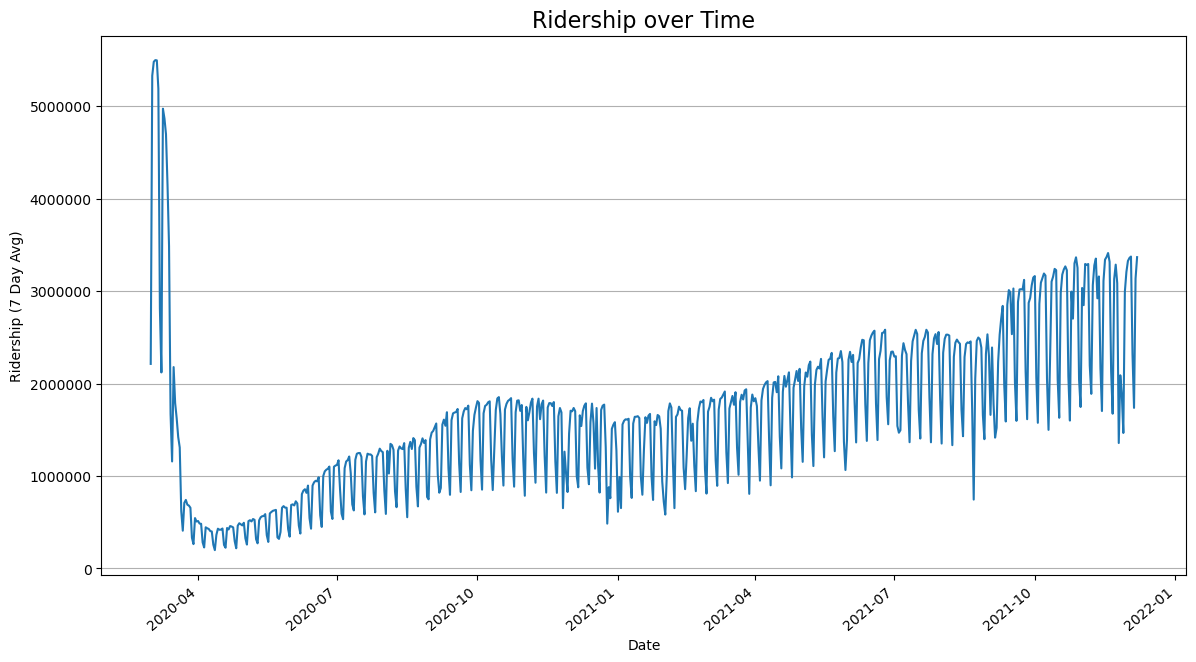

In [7]:
fig3, ax3 = plt.subplots(figsize=(14,7))
ax3=sns.lineplot(x=daily_riders["Date"], 
                  y=daily_riders["Riders"], 
                #   color='red'
                  )
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=40, ha="right")
ax3.ticklabel_format(axis='y', style='plain')
ax3.set_ylabel('Ridership (7 Day Avg)')
ax3.set_title('Ridership over Time', fontsize=16)

        
ax3.grid(True,axis='y')

In [8]:
daily_riders.set_index('Date',inplace=True)

In [9]:
daily_riders

,Riders
Date,
2020-03-01,2212965
2020-03-02,5329915
2020-03-03,5481103
2020-03-04,5498809
2020-03-05,5496453
...,...
2021-12-03,3374097
2021-12-04,2318147
2021-12-05,1737352


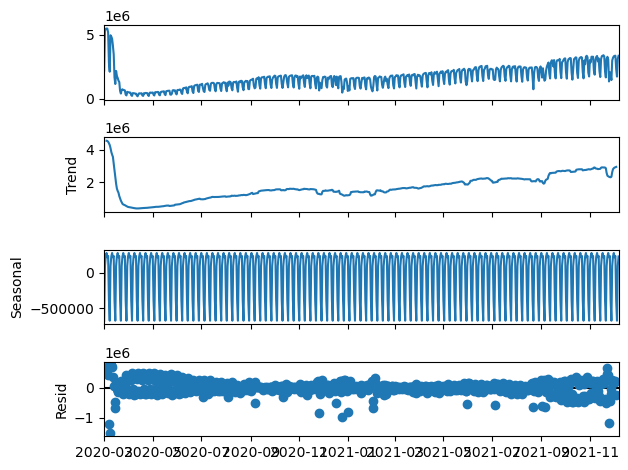

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_riders, model='additive')
decomposition.plot()
plt.show()

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [12]:
riders = daily_riders["Riders"]

In [13]:
riders

Date
2020-03-01    2212965
2020-03-02    5329915
2020-03-03    5481103
2020-03-04    5498809
2020-03-05    5496453
               ...   
2021-12-03    3374097
2021-12-04    2318147
2021-12-05    1737352
2021-12-06    3135869
2021-12-07    3367790
Name: Riders, Length: 647, dtype: int64

In [40]:
order = (1,1,1)
seasonal_order = (1,1,1,21)

In [41]:
train_size = int(len(daily_riders)*0.8)
train_data, test_data = daily_riders[:train_size], daily_riders[train_size:]

In [42]:
model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order,enforce_stationarity=False, enforce_invertibility=False)
result = model.fit()


c:\Users\tanve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\tanve\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [43]:
forecast = result.forecast(steps=len(test_data))

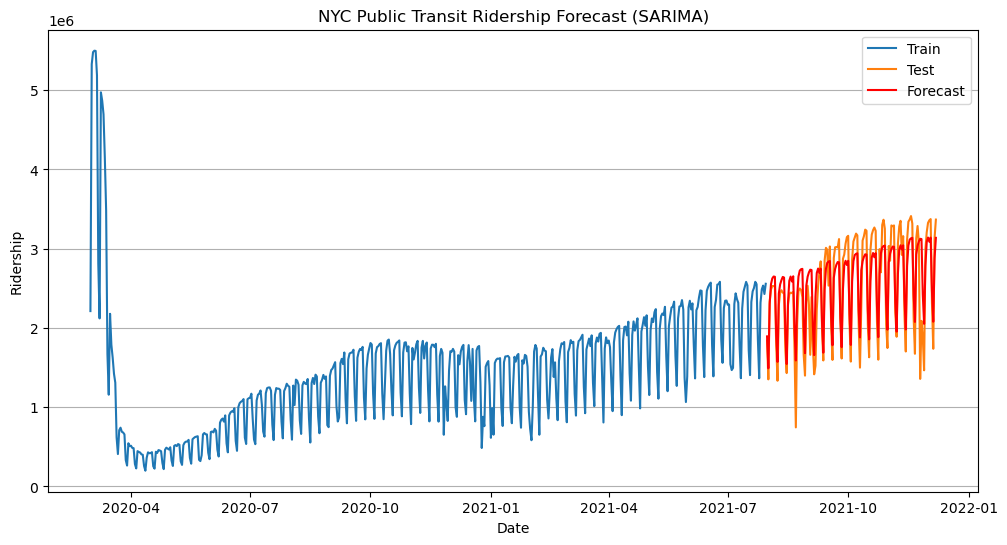

In [44]:
plt.figure(figsize=(12,6))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(test_data.index, forecast, label='Forecast', color='red')
plt.title('NYC Public Transit Ridership Forecast (SARIMA)')
plt.title('NYC Public Transit Ridership Forecast (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.legend()
plt.grid(axis='y')
plt.show()

In [ ]:
# import itertools

# p = d = q = range(0,3)
# P = D = Q = range(0,3)
# m = [7]

# pdq = list(itertools.product(p,d,q))
# seasonal_pdq = list(itertools.product(P,D,Q, m))

# best_aic = float('inf')
# best_params = None

# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#             model = SARIMAX(daily_riders, order=param, seasonal_order=param_seasonal)
#             results = model.fit()
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_params = (param, param_seasonal)
#         except:
#             continue
    
# print(f'Best SARIMA params: {best_params}')



In [45]:
forecast_steps = 183 #~next 6 months

forecast = result.get_forecast(steps=forecast_steps)

forecast_index = pd.date_range(start=daily_riders.index[-1], periods=forecast_steps)
forecast_series = pd.Series(forecast.predicted_mean.values, index=forecast_index)

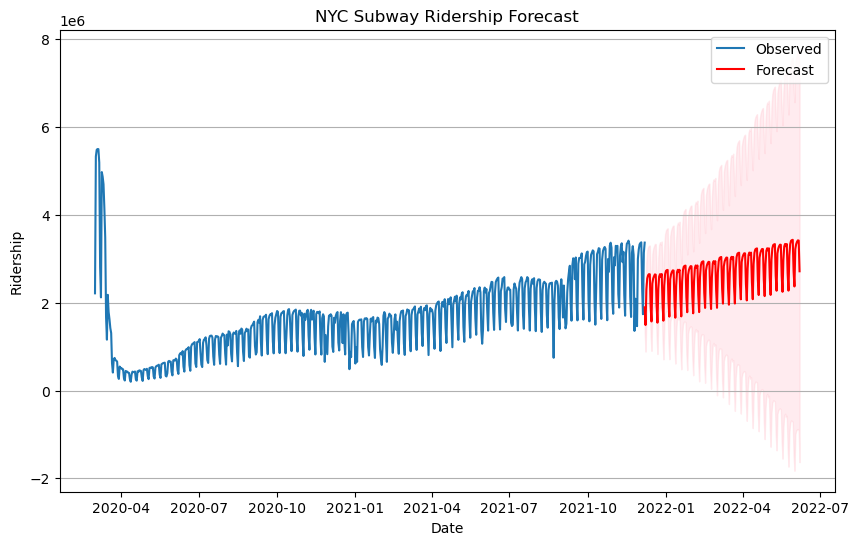

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(riders, label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast.conf_int().iloc[:, 0],
                 forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('NYC Subway Ridership Forecast')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.grid(axis='y')
plt.legend()
plt.show()

In [47]:
forecast.conf_int()

,lower Riders,upper Riders
2021-07-31,1.343591e+06,2.443499e+06
2021-08-01,8.853970e+05,2.095947e+06
2021-08-02,1.680163e+06,2.926751e+06
2021-08-03,1.918642e+06,3.185331e+06
2021-08-04,1.983408e+06,3.265676e+06
...,...,...
2022-01-25,-9.161061e+05,7.577642e+06
2022-01-26,-8.859582e+05,7.658122e+06
2022-01-27,-8.786648e+05,7.715452e+06
2022-01-28,-9.067236e+05,7.737140e+06


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

actual = daily_riders[-forecast_steps:]
predicted = forecast_series[:len(actual)]

mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
print(f'MAE: {(mae.round(2))}, MSE: {mse.round(2)}')

MAE: 700239.21, MSE: 742344225358.36


In [56]:
forecast_series

2021-12-07    1.893545e+06
2021-12-08    1.490672e+06
2021-12-09    2.303457e+06
2021-12-10    2.551986e+06
2021-12-11    2.624542e+06
                  ...     
2022-06-03    3.330768e+06
2022-06-04    3.386082e+06
2022-06-05    3.418393e+06
2022-06-06    3.415208e+06
2022-06-07    2.714930e+06
Freq: D, Length: 183, dtype: float64

In [57]:
forecast_df = pd.DataFrame(forecast_series)

In [58]:
forecast_df

,0
2021-12-07,1.893545e+06
2021-12-08,1.490672e+06
2021-12-09,2.303457e+06
2021-12-10,2.551986e+06
2021-12-11,2.624542e+06
...,...
2022-06-03,3.330768e+06
2022-06-04,3.386082e+06
2022-06-05,3.418393e+06
2022-06-06,3.415208e+06


In [67]:
forecast_df.rename(columns={0:'Predicted Ridership'}, inplace=True)

In [68]:
forecast_df["7 Day Avg (Predicted)"] = forecast_df["Predicted Ridership"].rolling(window=7).mean()

In [69]:
forecast_df

,Predicted Ridership,7 Day Avg (Predicted)
2021-12-07,1.893545e+06,NaN
2021-12-08,1.490672e+06,NaN
2021-12-09,2.303457e+06,NaN
2021-12-10,2.551986e+06,NaN
2021-12-11,2.624542e+06,NaN
...,...,...
2022-06-03,3.330768e+06,3.127932e+06
2022-06-04,3.386082e+06,3.124712e+06
2022-06-05,3.418393e+06,3.123836e+06
2022-06-06,3.415208e+06,3.121570e+06


In [74]:
forecast_df.index

DatetimeIndex(['2021-12-07', '2021-12-08', '2021-12-09', '2021-12-10',
               '2021-12-11', '2021-12-12', '2021-12-13', '2021-12-14',
               '2021-12-15', '2021-12-16',
               ...
               '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-01',
               '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
               '2022-06-06', '2022-06-07'],
              dtype='datetime64[ns]', length=183, freq='D')

In [75]:
daily_riders = pd.DataFrame(daily_riders)
daily_riders.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10',
               ...
               '2021-11-28', '2021-11-29', '2021-11-30', '2021-12-01',
               '2021-12-02', '2021-12-03', '2021-12-04', '2021-12-05',
               '2021-12-06', '2021-12-07'],
              dtype='datetime64[ns]', name='Date', length=647, freq=None)

In [76]:
daily_riders = daily_riders.rename_axis(None, axis=1)

In [78]:
daily_riders.index.name = None

In [79]:
daily_riders

,Riders
2020-03-01,2212965
2020-03-02,5329915
2020-03-03,5481103
2020-03-04,5498809
2020-03-05,5496453
...,...
2021-12-03,3374097
2021-12-04,2318147
2021-12-05,1737352
2021-12-06,3135869


In [80]:
daily_riders["7 Day Avg"] = daily_riders["Riders"].rolling(window=7).mean()

In [81]:
daily_riders

,Riders,7 Day Avg
2020-03-01,2212965,NaN
2020-03-02,5329915,NaN
2020-03-03,5481103,NaN
2020-03-04,5498809,NaN
2020-03-05,5496453,NaN
...,...,...
2021-12-03,3374097,2.801257e+06
2021-12-04,2318147,2.863789e+06
2021-12-05,1737352,2.902590e+06
2021-12-06,3135869,2.922569e+06


In [86]:
forecast_conf_interval = forecast.conf_int()

In [87]:
forecast_conf_interval["lower Riders 7 day avg"] = forecast_conf_interval["lower Riders"].rolling(window=7).mean()
forecast_conf_interval["upper Riders 7 day avg"] = forecast_conf_interval["upper Riders"].rolling(window=7).mean()

In [88]:
forecast_conf_interval

,lower Riders,upper Riders,lower Riders 7 day avg,upper Riders 7 day avg
2021-07-31,1.343591e+06,2.443499e+06,NaN,NaN
2021-08-01,8.853970e+05,2.095947e+06,NaN,NaN
2021-08-02,1.680163e+06,2.926751e+06,NaN,NaN
2021-08-03,1.918642e+06,3.185331e+06,NaN,NaN
2021-08-04,1.983408e+06,3.265676e+06,NaN,NaN
...,...,...,...,...
2022-01-25,-9.161061e+05,7.577642e+06,-1.042173e+06,7.298037e+06
2022-01-26,-8.859582e+05,7.658122e+06,-1.071051e+06,7.320476e+06
2022-01-27,-8.786648e+05,7.715452e+06,-1.097412e+06,7.345084e+06
2022-01-28,-9.067236e+05,7.737140e+06,-1.125003e+06,7.368142e+06


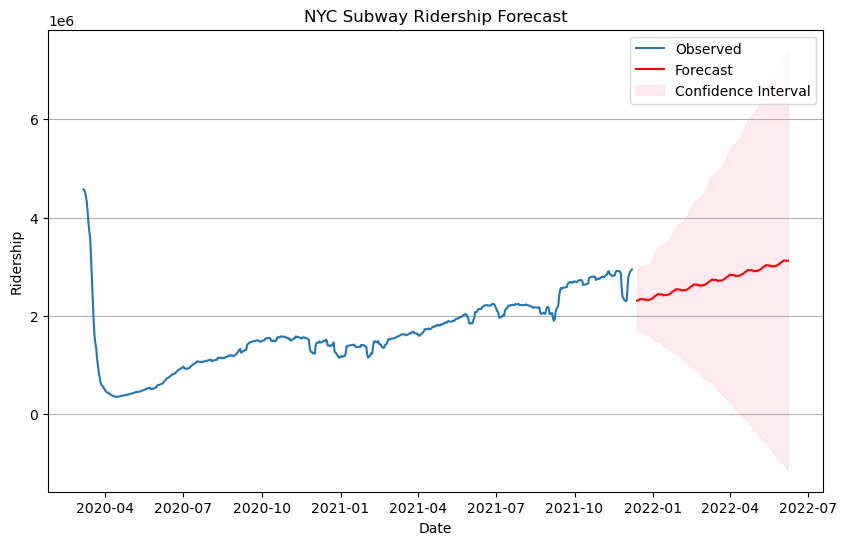

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(daily_riders["7 Day Avg"], label='Observed')
plt.plot(forecast_df["7 Day Avg (Predicted)"], label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_interval["lower Riders 7 day avg"],
                 forecast_conf_interval["upper Riders 7 day avg"], color='pink', alpha=0.3,
                 label = 'Confidence Interval')
plt.title('NYC Subway Ridership Forecast')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.grid(axis='y')
plt.legend()
plt.show()

In [92]:
forecast_index

DatetimeIndex(['2021-12-07', '2021-12-08', '2021-12-09', '2021-12-10',
               '2021-12-11', '2021-12-12', '2021-12-13', '2021-12-14',
               '2021-12-15', '2021-12-16',
               ...
               '2022-05-29', '2022-05-30', '2022-05-31', '2022-06-01',
               '2022-06-02', '2022-06-03', '2022-06-04', '2022-06-05',
               '2022-06-06', '2022-06-07'],
              dtype='datetime64[ns]', length=183, freq='D')

### Comparing forecasting to actual results

In [103]:
predicted_dates_ridership = pd.read_csv('./data/ridership_from_predicted_dates.csv')

In [104]:
predicted_dates_ridership = predicted_dates_ridership[["Date","Subways: Total Estimated Ridership"]]

In [106]:
predicted_dates_ridership["Date"] = pd.to_datetime(predicted_dates_ridership["Date"])

In [107]:
predicted_dates_ridership["Date"].dtype

dtype('<M8[ns]')

In [108]:
predicted_dates_ridership.set_index('Date', inplace=True)

In [109]:
predicted_dates_ridership.index.name = None

In [110]:
predicted_dates_ridership

,Subways: Total Estimated Ridership
2021-12-08,3378727
2021-12-09,3433600
2021-12-10,3417451
2021-12-11,2266265
2021-12-12,1829872
...,...
2022-06-03,3283271
2022-06-04,2178024
2022-06-05,1724983
2022-06-06,3092181


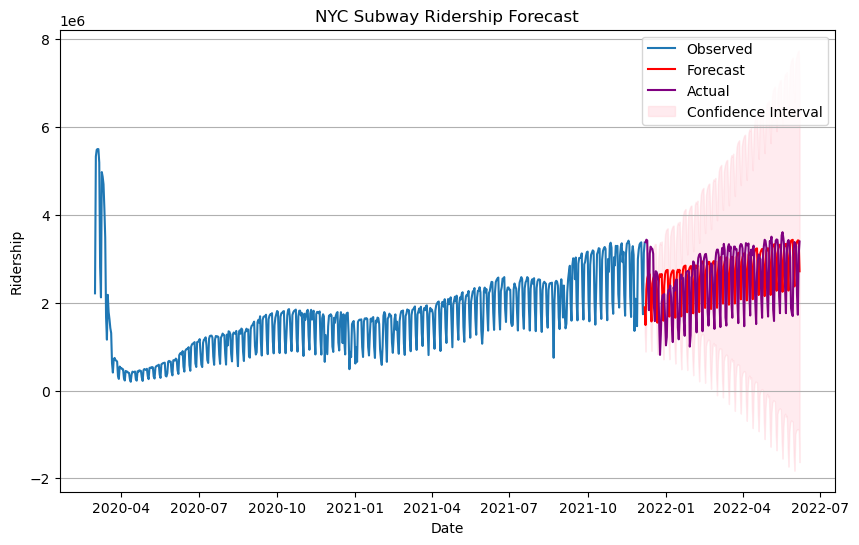

In [117]:
plt.figure(figsize=(10, 6))
plt.plot(riders, label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.plot(predicted_dates_ridership, label='Actual', color='purple')
plt.fill_between(forecast_index,
                 forecast_conf_interval["lower Riders"],
                 forecast_conf_interval["upper Riders"], color='pink', alpha=0.3,
                 label = 'Confidence Interval')
plt.title('NYC Subway Ridership Forecast')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.grid(axis='y')
plt.legend()
plt.show()

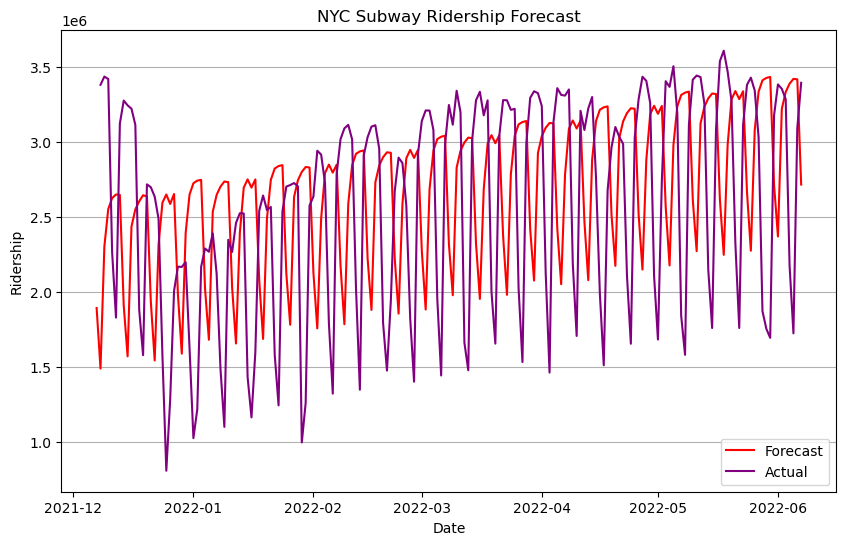

In [123]:
plt.figure(figsize=(10, 6))
# plt.plot(riders, label='Observed')
plt.plot(forecast_series, label='Forecast', color='red')
plt.plot(predicted_dates_ridership["Subways: Total Estimated Ridership"], label='Actual', color='purple')
# plt.fill_between(forecast_index,
#                  forecast.conf_int().iloc[:, 0],
#                  forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('NYC Subway Ridership Forecast')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.grid(axis='y')
plt.legend()
plt.show()

In [118]:
predicted_dates_ridership["7 Day Avg (Actual)"] = predicted_dates_ridership["Subways: Total Estimated Ridership"].rolling(window=7).mean()

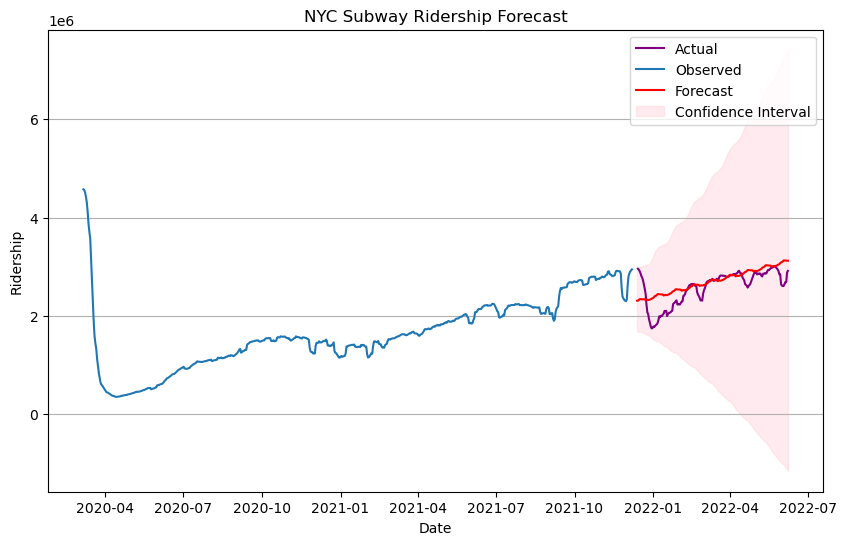

In [119]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_dates_ridership["7 Day Avg (Actual)"], label='Actual', color='purple')
plt.plot(daily_riders["7 Day Avg"], label='Observed')
plt.plot(forecast_df["7 Day Avg (Predicted)"], label='Forecast', color='red')
plt.fill_between(forecast_index,
                 forecast_conf_interval["lower Riders 7 day avg"],
                 forecast_conf_interval["upper Riders 7 day avg"], color='pink', alpha=0.3,
                 label = 'Confidence Interval')
plt.title('NYC Subway Ridership Forecast')
plt.xlabel('Date')
plt.ylabel('Ridership')
plt.grid(axis='y')
plt.legend()
plt.show()